In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the file
!unzip -q "$zip_path" -d "/content/data/"

In [ ]:
path = "/content/drive/MyDrive/TCDT/sp_data/" # customize your image folder path
os.listdir(path)

image_size = 256
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats),
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

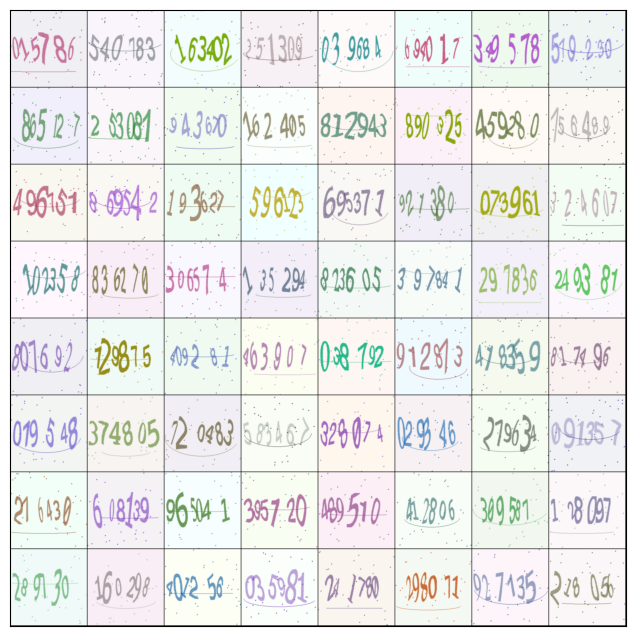

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

discriminator = nn.Sequential(
    nn.Conv2d(3,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1024,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator,device)

In [ ]:
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,1024,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

torch.Size([256, 3, 64, 64])


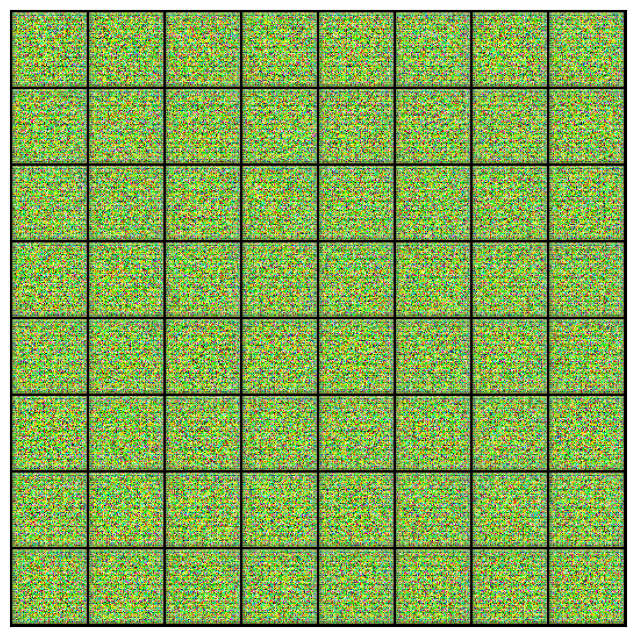

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator,device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    # real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_targets = torch.cuda.FloatTensor(real_images.size(0), 1).fill_(0.9)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    # fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_targets = torch.cuda.FloatTensor(fake_images.size(0), 1).fill_(0.1)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt):
    opt.zero_grad()
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()

In [ ]:
sample_dir = '/content/drive/MyDrive/TCDT/results'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


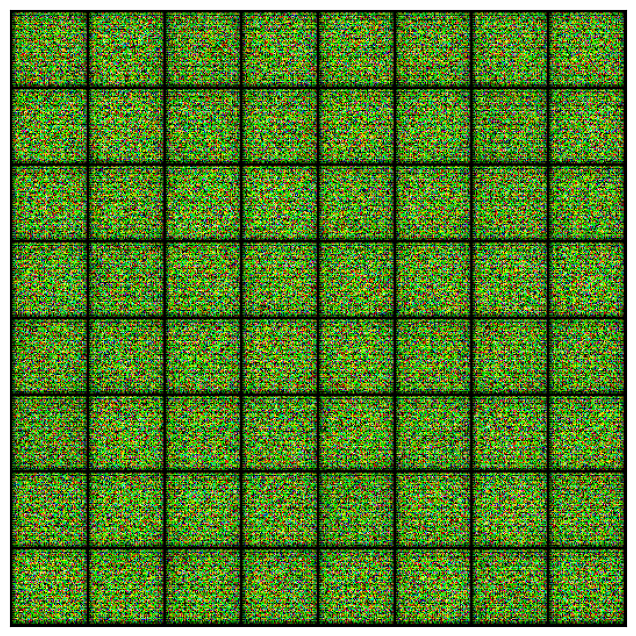

In [27]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 100
history = fit(epochs, lr)

<ipython-input-16-4dc401ed0aba>:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  real_targets = torch.cuda.FloatTensor(real_images.size(0), 1).fill_(0.9)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/generated/0999.png')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');